In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder ### available? Imho should be, like cmon
from sklearn.model_selection import train_test_split ###hopefully we're allowed to use this too

# 1. Bank data

In [3]:
bank_df = pd.read_csv('data/bank-additional-full.csv', sep=';')
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [15]:
for c in bank_df.columns:
    if bank_df[c].dtype=='O':
        print(bank_df[c].unique())

['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
['married' 'single' 'divorced' 'unknown']
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
['no' 'unknown' 'yes']
['no' 'yes' 'unknown']
['no' 'yes' 'unknown']
['telephone' 'cellular']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
['mon' 'tue' 'wed' 'thu' 'fri']
['nonexistent' 'failure' 'success']
['no' 'yes']


At first, it looks like there are no missing values in data. However, most off the categorical variables do have a special value `unknown` which is actually a missing value. While transforming the data by OHE, we can treat it like any other value or simply drop it to keep the columns linear independence. 

In [71]:
y = bank_df['y']
bank_df.drop('y', axis=1, inplace=True)

In [47]:
class Preprocessor:
    
    @staticmethod
    def train_test_split(X, y, train_subset_proportion=0.75, keep_y_balance=True):
        if set(X.index) != set(y.index):
            raise AttributeError('Indices in X and y are not indetical')
        n=X.shape[0]
        train_rows_n = int(train_subset_proportion * n)
        test_rows_n = n - train_rows_n 
        if keep_y_balance:
            if ((y.unique()!=0) & (y.unique()!=1)).any():
                raise ValueError('Using keep_y_balance requires y values to be 0 and 1.')
            pos_index = y[y==1].index
            neg_index = y[y==0].index
            train_pos_index = np.random.choice(pos_index, int(train_subset_proportion*len(pos_index)), replace=False)
            train_neg_index = np.random.choice(neg_index, int(train_subset_proportion*len(neg_index)), replace=False)
            test_pos_index = np.array(list(set(pos_index) - set(train_pos_index)))
            test_neg_index = np.array(list(set(neg_index) - set(train_neg_index)))
            train_index = np.concatenate((train_pos_index, train_neg_index))
            test_index = np.concatenate((test_pos_index, test_neg_index))
        else:
            train_index = np.random.choice(y.index, train_rows_n, replace=False)
            test_index = np.array(set(y.index) - set(train_index))
        return X.loc[train_index, :], X.loc[test_index, :], y.loc[train_index], y.loc[test_index]
    
    @staticmethod
    def remove_multicollinearity(X):
        """
        https://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels
        https://en.wikipedia.org/wiki/Multicollinearity#Detection
        """
        X = X.copy()
        while True:
            corr_m = np.corrcoef(X)
            eigenvalues, eigenvectors = np.linalg.eig(corr_m)
            #TODO
            print(eigenvalues)
            break
    
    def one_hot_encoding(self):
        #TODO
        pass        
            

In [53]:
x1, x2, y1, y2 = Preprocessor.train_test_split(bank_df, bank_df['y']=='yes')

In [59]:
y1.shape

(30891,)

In [58]:
y2.shape

(10297,)

# 3. Breast Cancer Wisconsin

In [183]:
wdbc_df=pd.read_csv('data/wdbc.csv')
#X_wdbc=wdbc_df.drop([0,1], axis=1)
#train_x,test_x,train_y,test_y=Preprocessor.train_test_split(wdbc_df.drop([0,1], axis=1),wdbc_df[1])
#train_x,test_x,train_y,test_y=train_test_split(X_wdbc, y_wdbc, stratify = y_wdbc)
#removing useless columns and transforming response variable into desired form
y_wdbc=wdbc_df['diagnosis']=="M"
X_wdbc=wdbc_df.drop(columns=["id","diagnosis","Unnamed: 32"])
X_wdbc.tail()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [135]:
X_wdbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

As we can see all features are non-null numeric type variables. Which means that in this case one-hot-encoding won't be needed. The only things left to do is to remove collinear and multicollinear ones (maybe remove some outliers? from data) and split data into training and testing sets.

In [141]:
wdbc_df.tail()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
564,926424,1.0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,1.0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,1.0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,1.0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN
568,92751,0.0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,NaN


Correlation matrix showing that we should remove a fair amount of variables

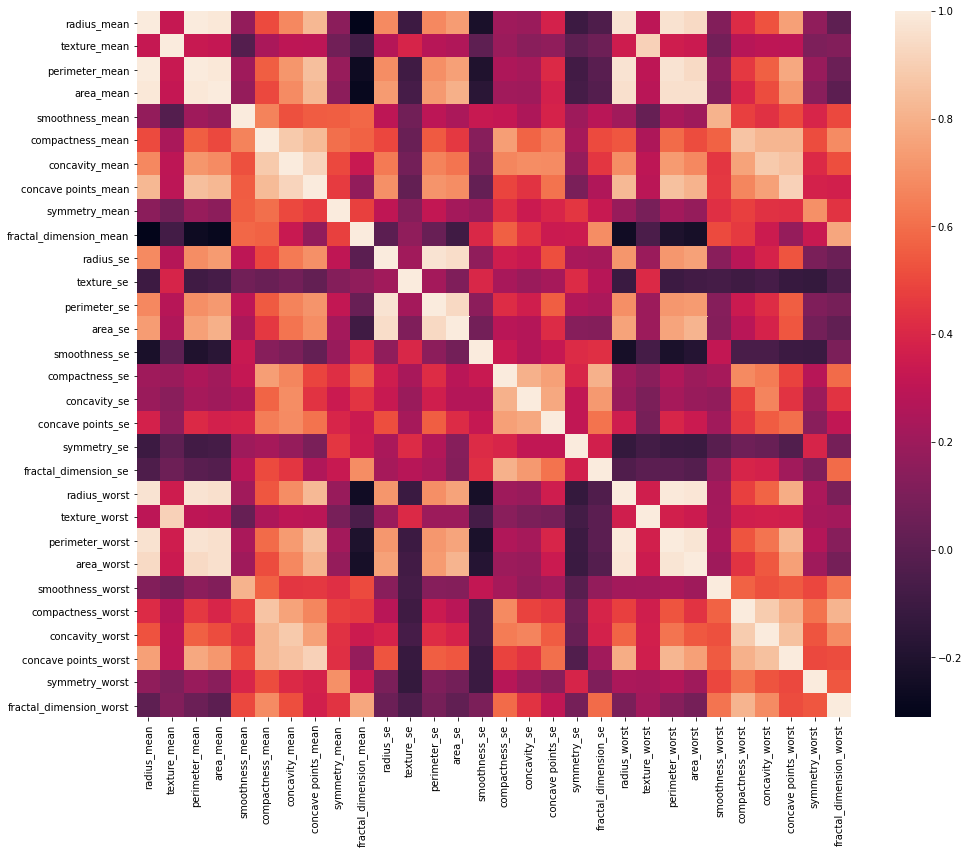

In [185]:
plt.figure(figsize=(16,13))
sns.heatmap(X_wdbc.corr())
plt.show()

Removal of variables based only on correlation

In [201]:
thres_value=0.7
cor_matrix = X_wdbc.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= thres_value)]
len(to_drop)
X_wdbc_cleaned_corr=X_wdbc.drop(columns=to_drop)
X_wdbc_cleaned_corr.columns

Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se',
       'smoothness_se', 'symmetry_se', 'symmetry_worst'],
      dtype='object')

Removal of variables using Variance Inflation Factor (VIF)

In [199]:
#source: https://www.kaggle.com/remilpm/how-to-remove-multicollinearity
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X


Mult_Coll = ReduceVIF()
X_wdbc_cleaned = Mult_Coll.fit_transform(X_wdbc)
X_wdbc_cleaned.tail()

ReduceVIF fit
ReduceVIF transform
Dropping radius_mean with vif=63306.17203588469
Dropping radius_worst with vif=7573.943486033555
Dropping perimeter_mean with vif=3901.901687119607
Dropping perimeter_worst with vif=668.3854404127386
Dropping fractal_dimension_mean with vif=508.08682464149285
Dropping smoothness_worst with vif=368.0533791867144
Dropping texture_worst with vif=309.54444960438434
Dropping fractal_dimension_worst with vif=184.67972071700538
Dropping symmetry_worst with vif=167.30971478504884
Dropping concavity_mean with vif=142.29904340088856
Dropping radius_se with vif=104.99215955661566
Dropping concave points_worst with vif=100.94649021325061
Dropping smoothness_mean with vif=86.99658368431041
Dropping compactness_mean with vif=74.72314541276282
Dropping area_mean with vif=67.47169344522399
Dropping compactness_worst with vif=49.02308700997905
Dropping perimeter_se with vif=43.72833047786977
Dropping symmetry_mean with vif=36.0757931560618
Dropping texture_mean with vi

,concave points_mean,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,concavity_worst
564,0.13890,1.256,158.70,0.010300,0.05198,0.01114,0.004239,0.4107
565,0.09791,2.463,99.04,0.005769,0.03950,0.01898,0.002498,0.3215
566,0.05302,1.075,48.55,0.005903,0.04730,0.01318,0.003892,0.3403
567,0.15200,1.595,86.22,0.006522,0.07117,0.02324,0.006185,0.9387
568,0.00000,1.428,19.15,0.007189,0.00000,0.02676,0.002783,0.0000


In [197]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_wdbc_cleaned, y_wdbc)
model.score(X_wdbc_cleaned, y_wdbc)

0.9261862917398945

In [179]:
print(X_wdbc_cleaned.columns)
X_wdbc_cleaned_corr.columns

Index(['texture_se', 'area_se', 'smoothness_se', 'concavity_se', 'symmetry_se',
       'fractal_dimension_se', 'concavity_worst'],
      dtype='object')


Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se',
       'smoothness_se', 'symmetry_se', 'symmetry_worst'],
      dtype='object')